In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Importing data (just original for now)

In [3]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST',
       'g_flux_corr', 'nb921_hsc_flux_corr'
    ]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [4]:
data = pd.read_csv("../../Data/Fangyou_data/Cleaned/combined_using_similar_columns.csv")

In [5]:
X = data[features_num]
y = data[[y_column, 'Source', 'Xray', 'Opt_spec', 'IRAGN', 'Donley']]

# Dropping columns with little data (optional)

In [6]:
X = X.drop(columns=['NUV_flux_corr', 'Bw_flux_corr', 'y_flux_corr', 'H_flux_corr', 'Ks_flux_corr', 'K_flux_corr',
                   'g_flux_corr', 'nb921_hsc_flux_corr'])

## Filling nan's

In [7]:
imp = IterativeImputer(max_iter=100, min_value=0)
X_filled = imp.fit_transform(X)

## Normalisations

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
X_filled = scaler.fit_transform(X_filled)

## Kmeans

In [98]:
n = 8
kmeans = KMeans(n_clusters=n, random_state=0)
kmeans.fit(X_filled)

KMeans(random_state=0)

In [99]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([9070,    1,   10,    3,   34, 3900,  143,    1]))

In [162]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 15)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_filled)
    kmeanModel.fit(X_filled)
  
    distortions.append(sum(np.min(cdist(X_filled, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_filled.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X_filled, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_filled.shape[0]
    mapping2[k] = kmeanModel.inertia_

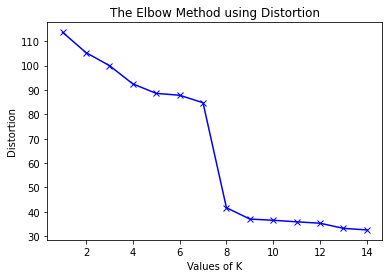

In [84]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [188]:
data['KMeans'] = kmeans.labels_
data.to_csv('Kmeans.csv', index=False)

# Spectral clustering

In [86]:
from sklearn.cluster import SpectralClustering

In [ ]:
clustering = SpectralClustering(n_clusters=5, n_jobs=8, verbose=True, 
                               #affinity='nearest_neighbors',
                               assign_labels="discretize").fit(X_filled)
clustering.fit(X_filled)

In [77]:
classes = clustering.labels_
for i in range(5):
    print(i, ":")
    print(y['Classification'].iloc[classes==i].value_counts()/y['Classification'].value_counts())
    print()

0 :


IndexError: Boolean index has wrong length: 1000 instead of 77609

 # GMM

In [16]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [10]:
gm = GaussianMixture(n_components=2, random_state=0)
gm.fit(X_filled)

GaussianMixture(n_components=2, random_state=0)

In [15]:
from scipy.spatial.distance import cdist

bic_means = []
bic_stds = []
K = range(1, 10)

for k in K:
    print(k)
    trial = []
    for i in range(8):
        
        # Building and fitting the model
        gm = GaussianMixture(n_components=k).fit(X_filled)
        gm.fit(X_filled)

        trial.append(gm.bic(X_filled))
    bic_means.append(np.mean(trial))
    bic_stds.append(np.std(trial))

1
2
3
4
5
6
7
8
9


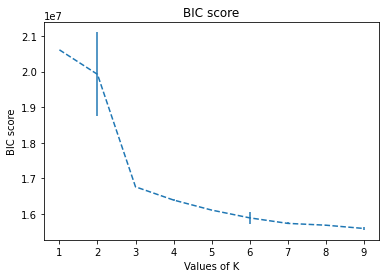

In [16]:
plt.errorbar(x=K, y=bic_means, yerr=bic_stds, ls='--')
plt.xlabel('Values of K')
plt.ylabel('BIC score')
plt.title('BIC score')
plt.show()

In [22]:
gm = GaussianMixture(n_components=8, random_state=0)
gm.fit(X_filled)

GaussianMixture(n_components=8, random_state=0)

In [309]:
data['gmm'] = gm.predict(X_filled)
data.to_csv('gmm.csv', index=False)

In [18]:
n=3
gm = GaussianMixture(n_components=n, random_state=0)
gm.fit(X_filled)

classes = gm.predict(X_filled)
for i in range(n):
    print(i, ":")
    print(y['Classification'].iloc[classes==i].value_counts())
    print()

0 :
star-forming galaxy                                     37020
jet-mode radio AGN/low-excitation radio galaxy           7148
radio-quiet AGN                                          3150
quasar-like radio AGN / high-excitation radio galaxy      380
Name: Classification, dtype: int64

1 :
star-forming galaxy                                     1624
jet-mode radio AGN/low-excitation radio galaxy          1393
radio-quiet AGN                                          711
quasar-like radio AGN / high-excitation radio galaxy     304
Name: Classification, dtype: int64

2 :
star-forming galaxy                                     17996
jet-mode radio AGN/low-excitation radio galaxy           4226
radio-quiet AGN                                          3009
quasar-like radio AGN / high-excitation radio galaxy      648
Name: Classification, dtype: int64



In [12]:
n=6
gm = GaussianMixture(n_components=n, random_state=0)
gm.fit(X_filled)

classes = gm.predict(X_filled)
for i in range(n):
    print(i, ":")
    print(y['Classification'].iloc[classes==i].value_counts()/y['Classification'].value_counts())
    print()

0 :
jet-mode radio AGN/low-excitation radio galaxy          0.113652
quasar-like radio AGN / high-excitation radio galaxy    0.247748
radio-quiet AGN                                         0.342358
star-forming galaxy                                     0.148093
Name: Classification, dtype: float64

1 :
jet-mode radio AGN/low-excitation radio galaxy          0.014021
quasar-like radio AGN / high-excitation radio galaxy    0.067568
radio-quiet AGN                                         0.069578
star-forming galaxy                                     0.017267
Name: Classification, dtype: float64

2 :
star-forming galaxy                                     0.453143
jet-mode radio AGN/low-excitation radio galaxy          0.418501
radio-quiet AGN                                         0.388210
quasar-like radio AGN / high-excitation radio galaxy    0.219219
Name: Classification, dtype: float64

3 :
jet-mode radio AGN/low-excitation radio galaxy          0.206626
quasar-like radio AGN / h